# Image Classification using CNNs on the Compcars dataset

**Group members:**\
Bresolin Riccardo\
Serain Hermann\
Zonta Angelica

# Dowload Compcar Dataset

In [1]:
!git clone https://github.com/herm23/Project-NNDL.git

Cloning into 'Project-NNDL'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 81 (delta 18), reused 76 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 4.22 MiB | 17.85 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [2]:
%cd Project-NNDL/

/content/Project-NNDL


In [3]:
!pip install -U -q PyDrive

In [4]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

In [5]:
#Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# Compcar folder id
folder_id = '18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg'
# Local folder to save the data
save_path = '/content/Project-NNDL/compcar_dataset'
os.makedirs(save_path, exist_ok=True)
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
for file in file_list:
    print(f"Downloading {file['title']}")
    file.GetContentFile(os.path.join(save_path, file['title']))

In [7]:
!apt-get install -y p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [8]:
%cd /content/Project-NNDL/compcar_dataset

/content/Project-NNDL/compcar_dataset


password per unzippare: d89551fd190e38

In [9]:
#...unziping data
!7z x data.zip -o./compcar_dataset/unzipped


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 391417395 bytes (374 MiB)

Extracting archive: data.zip
  1% 4096 Open               90% 299008 Open                --
Path = data.zip
Type = zip
Physical Size = 391417395
Embedded Stub Size = 4
64-bit = +
Total Physical Size = 16539487795
Multivolume = +
Volume Index = 22
Volumes = 23

  0%    
Enter password (will not be echoed):
  0% 5 - data/image/1/1101/2011/07b90decb92ba6.jpg                                                    0% 145 - data/image/1/1112/2013/1ae9f749a938af.jpg                  

# Dataset definition

In [27]:
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

#Only for training
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), #or p=0.1
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Imagenet default normalization values
])

#For validation and testing
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [28]:
import random
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CompCarsDataset(Dataset):
    def __init__(self, root_dir, max_classes, transform=None):
        """
        root_dir: compcar dataset images root
        transform: pythorch transforms
        max_classes: num of classes (make) taken into account from the dataset (max 163)
        """

        self.root_dir = root_dir
        self.transform = transform

        #Se qualcosa non va torna qua :)
        # self.class_folders = sorted([f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))],
        #                             key=lambda x: int(x)
        #                             )[:max_classes]

        # Selecting at random max_classes folders
        all_folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
        self.class_folders = random.sample(all_folders, min(max_classes, len(all_folders)))
        self.class_to_idx = {folder: idx for idx, folder in enumerate(self.class_folders)}

        self.samples = []
        for make_folder in self.class_folders:
            make_path = os.path.join(root_dir, make_folder)
            label = self.class_to_idx[make_folder] #the label is an index that represent the make

            for model_folder in os.listdir(make_path):
                model_path = os.path.join(make_path, model_folder)

                if os.path.isdir(model_path): #check existence
                  for year_folder in os.listdir(model_path):
                      year_path = os.path.join(model_path, year_folder)

                      if os.path.isdir(year_path):
                        for img_name in os.listdir(year_path):
                            img_path = os.path.join(year_path, img_name)
                            self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [29]:
from torch.utils.data import DataLoader, random_split
import torch

# Constants
root_dir = "/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/image"

num_classes = 40
num_workers = os.cpu_count() #parallel avaiable threads
device = "cuda" if torch.cuda.is_available() else "cpu"
train_perc = 0.8
test_perc = 0.1
batch_size = 64
epochs=50
#usati nell'optimizer
learning_rate = 1e-2
w_decay = 1e-5

all_dataset = CompCarsDataset(root_dir=root_dir, transform=transform, max_classes=num_classes)
dataset_size = len(all_dataset)

train_size = int(train_perc * dataset_size)
test_size = int(test_perc * dataset_size)
val_size = dataset_size - train_size - test_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(all_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [18]:
all_labels = []
for _, batch_y in train_loader:
    all_labels.append(batch_y)
all_labels = torch.cat(all_labels)

print("Min label:", all_labels.min().item())
print("Max label:", all_labels.max().item())

print("Range cercat: 0 to", num_classes - 1)

KeyboardInterrupt: 

# ResNet 50

In [30]:
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU

class MainPath(Module):

    def __init__(self, in_channels, filters, kernel_size, stride=1):
        super().__init__()
        F1, F2, F3 = filters
        self.main_path = Sequential(
            Conv2d(in_channels, F1, kernel_size=1, stride=stride),
            BatchNorm2d(F1),
            ReLU(),
            Conv2d(F1, F2, kernel_size=kernel_size, padding=kernel_size//2),
            BatchNorm2d(F2),
            ReLU(),
            Conv2d(F2, F3, kernel_size=1),
            BatchNorm2d(F3),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y

class IdentityBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size)
        self.relu = ReLU()

    def forward(self, x):
        y = self.relu(self.main_path(x) + x)
        return y

class ConvolutionalBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size, stride=2)
        self.relu = ReLU()
        self.shortcut_path = Sequential(
            Conv2d(in_channels, filters[2], kernel_size=1, stride=2),
            BatchNorm2d(filters[2])
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.relu(self.main_path(x) + self.shortcut_path(x))
        return y

In [31]:
from torch.nn import MaxPool2d, AvgPool2d, Linear, Dropout
class ResNet50(Module):

    def __init__(self):
        super().__init__()
        self.network = Sequential(
            Conv2d(3, 64, kernel_size=7, stride=2),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=3, stride=2),
            ConvolutionalBlock(64, [64, 64, 256], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(256, [64, 64, 256], kernel_size=3),
            IdentityBlock(256, [64, 64, 256], kernel_size=3),
            ConvolutionalBlock(256, [128, 128, 512], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            ConvolutionalBlock(512, [256, 256, 1024], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            ConvolutionalBlock(1024, [512, 512, 2048], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(2048, [512, 512, 2048], kernel_size=3),
            IdentityBlock(2048, [512, 512, 2048], kernel_size=3),
            torch.nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classification_layer = Linear(2048, num_classes)
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x).reshape((x.shape[0], -1))
        y = self.classification_layer(y)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

# Calling functions

In [32]:
import torch
import torch.nn.functional as F
from torch.nn import Module

class FocalLoss(Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()

        # Focal loss parameres
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            alpha_t = self.alpha[targets]
            loss = alpha_t * (1 - probs) ** self.gamma * log_probs
        else:
            loss = (1 - probs) ** self.gamma * log_probs

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise ValueError(f"Invalid reduction mode: {self.reduction}")

# Training phase

In [ ]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
from collections import Counter
import numpy as np

# Data collection
max_patient = 15
patient = 0
train_losses = []
val_losses = []
val_accs = []

# Net definition
model = ResNet50()
model.to(device)

# Optimizer
opt = Adam(model.parameters(), lr=learning_rate, weight_decay=w_decay)
loss_fn = FocalLoss(alpha=None, gamma=1.0)
#loss_fn = CrossEntropyLoss()

best_val = np.inf
for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(train_loader)

    total_loss = 0.0
    correct = 0
    total = 0

    #TRAINING
    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        #forward
        y_pred = model(batch_x)
        loss = loss_fn(y_pred, batch_y)

        #backward
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Update running loss for display
        total_loss += loss.item()
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")
        # iterator.set_description(f"Train loss: {running_loss / (i+1):.4f}", refresh=True)

    # Avg train loss
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    #VALIDATION
    model.eval()
    with torch.no_grad():
        val_total_loss = 0.0
        correct_preds = 0
        total_value = 0

        for batch_x, batch_y in tqdm(val_loader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            #Compute predition
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)

            #Collect statistics for the plot
            val_total_loss += loss.item()
            preds = torch.argmax(y_pred, dim=1)
            total_value += batch_y.size(0)
            correct_preds += (preds == batch_y).sum().item()

        val_loss = val_total_loss / len(val_loader)
        val_acc = correct_preds / total_value

        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")

    if val_loss < best_val:
      print("Saved Model")
      torch.save(model.state_dict(), "model.pt")
      best_val = val_loss
      patient = 0
    else:
      patient += 1
      print("Patient: ", patient)
      if patient >= max_patient:
        print("Early stopping triggered !")
        break

Epoch: 1


100%|██████████| 51/51 [00:04<00:00, 11.75it/s]


Validation loss: 3.0084, accuracy: 0.1250
Saved Model
Epoch: 2


100%|██████████| 51/51 [00:04<00:00, 11.32it/s]


Validation loss: 2.9440, accuracy: 0.1241
Saved Model
Epoch: 3


100%|██████████| 51/51 [00:04<00:00, 11.56it/s]


Validation loss: 2.9318, accuracy: 0.1296
Saved Model
Epoch: 4


100%|██████████| 51/51 [00:04<00:00, 11.85it/s]


Validation loss: 2.8851, accuracy: 0.1374
Saved Model
Epoch: 5


100%|██████████| 51/51 [00:04<00:00, 11.31it/s]


Validation loss: 2.8438, accuracy: 0.1358
Saved Model
Epoch: 6


100%|██████████| 51/51 [00:04<00:00, 12.04it/s]


Validation loss: 2.8320, accuracy: 0.1411
Saved Model
Epoch: 7


100%|██████████| 51/51 [00:04<00:00, 11.66it/s]


Validation loss: 2.8387, accuracy: 0.1383
Patient:  1
Epoch: 8


100%|██████████| 51/51 [00:04<00:00, 11.43it/s]


Validation loss: 2.8702, accuracy: 0.1337
Patient:  2
Epoch: 9


100%|██████████| 51/51 [00:04<00:00, 11.33it/s]


Validation loss: 2.6553, accuracy: 0.1730
Saved Model
Epoch: 10


100%|██████████| 51/51 [00:04<00:00, 11.97it/s]


Validation loss: 2.8002, accuracy: 0.1467
Patient:  1
Epoch: 11


100%|██████████| 51/51 [00:04<00:00, 11.86it/s]


Validation loss: 2.5983, accuracy: 0.1856
Saved Model
Epoch: 12


100%|██████████| 51/51 [00:04<00:00, 11.15it/s]


Validation loss: 2.7296, accuracy: 0.1730
Patient:  1
Epoch: 13


100%|██████████| 51/51 [00:04<00:00, 11.54it/s]


Validation loss: 2.5562, accuracy: 0.1940
Saved Model
Epoch: 14


  0%|          | 0/51 [00:00<?, ?it/s]

# Plot

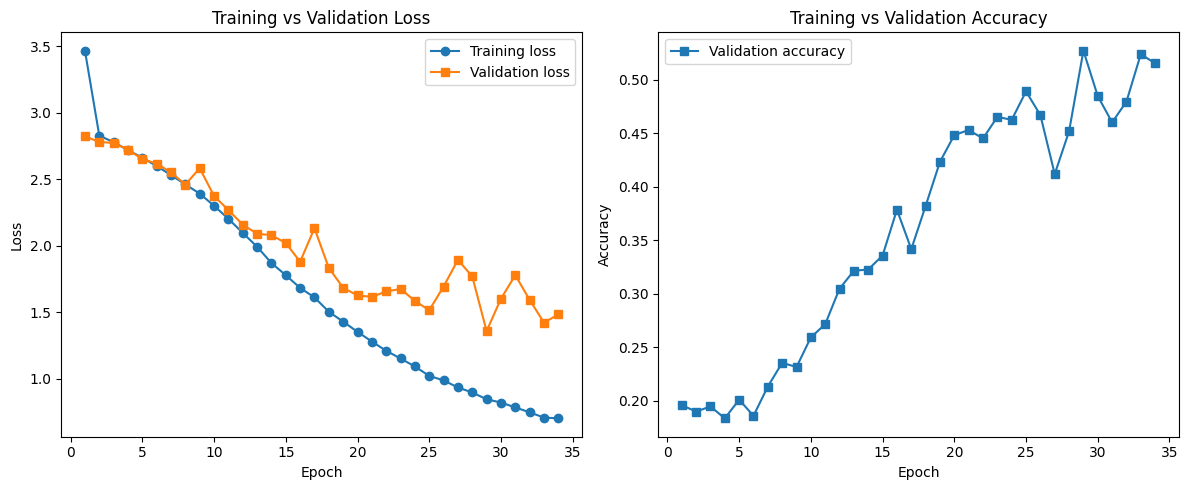

In [23]:
import matplotlib.pyplot as plt

# train_losses, val_losses, train_accs, val_accs
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12, 5))

# Plot la loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training loss', marker='o')
plt.plot(epochs, val_losses, label='Validation loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
# plt.plot(epochs, train_accs, label='Training accuracy', marker='o')
plt.plot(epochs, val_accs, label='Validation accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

